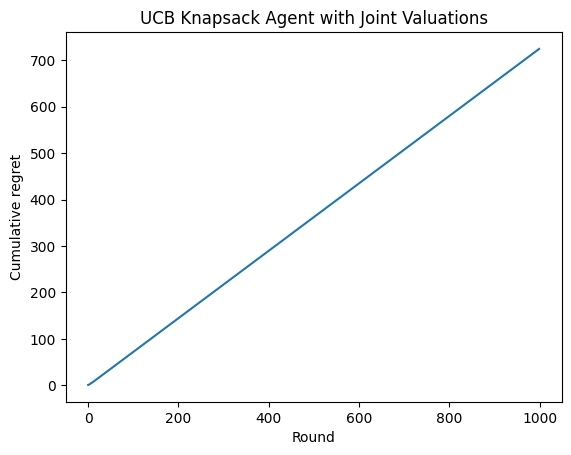

In [9]:
import numpy as np
from scipy import stats

# -----------------------------
# Multi-product pricing environment
# -----------------------------
class MultiProductPricingEnvironment:
    def __init__(self, costs, prices_grid, mean=None, cov=None, marginal="beta", a=2, b=5):
        self.costs = np.asarray(costs, dtype=float)
        self.d = len(costs)
        self.prices_grid = prices_grid
        self.mean = np.zeros(self.d) if mean is None else np.asarray(mean, dtype=float)
        self.cov  = 0.1*np.eye(self.d) if cov is None else np.asarray(cov, dtype=float)
        self._mvn = stats.multivariate_normal(mean=self.mean, cov=self.cov)

        # Beta marginals
        self.marginals = [stats.beta(a,b) for _ in range(self.d)]

    def sample_valuations(self, n_customers):
        z = self._mvn.rvs(size=n_customers)
        u = stats.norm.cdf(z)
        vals = np.column_stack([m.ppf(u[:,i]) for i,m in enumerate(self.marginals)])
        return vals

    def round(self, chosen_prices, n_customers=100):
        chosen_prices = np.asarray(chosen_prices, dtype=float)
        vals = self.sample_valuations(n_customers)
        d_t = (vals >= chosen_prices).astype(int).sum(axis=0)
        r_t = np.dot(chosen_prices - self.costs, d_t)/n_customers
        return d_t, r_t

# -----------------------------
# Knapsack DP
# -----------------------------
def knapsack_dp(values, weights, capacity):
    n = len(values)
    M = np.zeros((n+1, capacity+1))
    keep = np.zeros((n+1, capacity+1))
    for i in range(1, n+1):
        for w in range(capacity+1):
            if weights[i-1] <= w:
                val_with = values[i-1] + M[i-1, w-weights[i-1]]
                val_without = M[i-1, w]
                if val_with > val_without:
                    M[i,w] = val_with
                    keep[i,w] = 1
                else:
                    M[i,w] = val_without
            else:
                M[i,w] = M[i-1,w]
    # Backtrack
    chosen = []
    w = capacity
    for i in range(n,0,-1):
        if keep[i,w]==1:
            chosen.append(i-1)
            w -= weights[i-1]
    return chosen

# -----------------------------
# UCB agent with budget constraint
# -----------------------------
class UCBKnapsackAgent:
    def __init__(self, prices_grid, costs, budget):
        self.prices_grid = prices_grid
        self.costs = costs
        self.budget = budget
        self.d = len(prices_grid)
        self.n_prices = [len(grid) for grid in prices_grid]
        self.counts = [np.zeros(n) for n in self.n_prices]
        self.values = [np.zeros(n) for n in self.n_prices]
        self.t = 1

    def pull_arm(self):
        ucb_scores = []
        for i in range(self.d):
            scores = self.values[i] + np.sqrt(2*np.log(max(1,self.t)) / (self.counts[i]+1e-6))
            ucb_scores.append(scores)
        flat_scores = []
        flat_weights = []
        flat_indices = []
        for i, grid in enumerate(self.prices_grid):
            for j, price in enumerate(grid):
                flat_scores.append(ucb_scores[i][j])
                flat_weights.append(price)
                flat_indices.append((i,j))
        cap = int(self.budget*100)
        weights_int = [int(w*100) for w in flat_weights]
        chosen_flat = knapsack_dp(flat_scores, weights_int, cap)
        chosen_prices = np.zeros(self.d)
        for i in range(self.d):
            chosen_prices[i] = self.prices_grid[i][0]
        for idx in chosen_flat:
            prod, price_idx = flat_indices[idx]
            chosen_prices[prod] = self.prices_grid[prod][price_idx]
        self.last_chosen = chosen_prices
        return chosen_prices

    def update(self, per_product_rewards):
        for i, r in enumerate(per_product_rewards):
            price_idx = np.where(self.prices_grid[i]==self.last_chosen[i])[0][0]
            self.counts[i][price_idx] += 1
            self.values[i][price_idx] += (r - self.values[i][price_idx]) / self.counts[i][price_idx]
        self.t += 1

# -----------------------------
# Simulation
# -----------------------------
np.random.seed(42)
d = 4
prices_grid = [np.linspace(0.1, 1.0, 5) for _ in range(d)]
costs = [0.2, 0.3, 0.1, 0.25]
budget = 2.0
T = 1000
n_customers = 100
n_trials = 5

# Clairvoyant baseline (expected reward for each product-price)
env = MultiProductPricingEnvironment(costs, prices_grid)
vals = env.sample_valuations(10000)
W = np.zeros((d, len(prices_grid[0])))
for i, grid in enumerate(prices_grid):
    for j, p in enumerate(grid):
        W[i,j] = np.mean(np.maximum(vals[:,i]-costs[i],0)*(vals[:,i]>=p))
clairvoyant_reward = W.max(axis=1).sum()  # sum of best per-product

all_regrets = []
for _ in range(n_trials):
    env = MultiProductPricingEnvironment(costs, prices_grid)
    agent = UCBKnapsackAgent(prices_grid, costs, budget)
    agent_rewards = []
    for t in range(T):
        chosen_prices = agent.pull_arm()
        _, r_t = env.round(chosen_prices, n_customers)
        per_product_rewards = chosen_prices - costs
        agent.update(per_product_rewards)
        agent_rewards.append(r_t)
    cumulative_regret = np.cumsum(clairvoyant_reward - np.array(agent_rewards))
    all_regrets.append(cumulative_regret)

all_regrets = np.array(all_regrets)
avg_regret = all_regrets.mean(axis=0)
import matplotlib.pyplot as plt
plt.plot(avg_regret)
plt.xlabel("Round")
plt.ylabel("Cumulative regret")
plt.title("UCB Knapsack Agent with Joint Valuations")
plt.show()


In [7]:
import numpy as np
from scipy import stats
from scipy.optimize import linear_sum_assignment

# -------------------------
# Multi-product pricing environment
# -------------------------
class MultiProductPricingEnvironment:
    def __init__(self, costs, prices, mean=None, cov=None, marginal="beta", **marginal_params):
        self.costs  = np.asarray(costs, dtype=float)
        self.prices = np.asarray(prices, dtype=float)
        self.d = len(prices)

        # Gaussian copula
        self.mean = np.zeros(self.d) if mean is None else np.asarray(mean, dtype=float)
        self.cov  = 0.1*np.eye(self.d) if cov is None else np.asarray(cov, dtype=float)
        self._mvn = stats.multivariate_normal(mean=self.mean, cov=self.cov)

        # marginals
        if marginal == "uniform":
            self.marginals = [stats.uniform(0,1) for _ in range(self.d)]
        elif marginal == "beta":
            a = np.atleast_1d(marginal_params.get("a", 2))
            b = np.atleast_1d(marginal_params.get("b", 5))
            self.marginals = [stats.beta(ai, bi)
                              for ai, bi in zip(np.resize(a,self.d),
                                                np.resize(b,self.d))]
        else:
            raise ValueError(f"Unsupported marginal: {marginal}")

    def sample_valuations(self, n_customers):
        z = self._mvn.rvs(size=n_customers)
        u = stats.norm.cdf(z)
        vals = np.column_stack([m.ppf(u[:,i]) for i,m in enumerate(self.marginals)])
        return vals

    def round(self, chosen_prices, n_customers):
        vals = self.sample_valuations(n_customers)
        chosen_prices = np.asarray(chosen_prices, dtype=float)
        d_t = (vals >= chosen_prices).astype(int).sum(axis=0)
        r_t = float(np.dot(chosen_prices - self.costs, d_t)/n_customers)
        return d_t, r_t

# -------------------------
# Dynamic programming functions (knapsack)
# -------------------------
def solve_knapsack_cell(v, s, n, c, M):
    value_no_n = M[n-1,c] if n > 0 else 0
    if s[n] > c:
        return value_no_n, 0
    value_with_n = v[n] + M[n-1, c-s[n]] if n>0 else v[n]
    if value_no_n > value_with_n:
        return value_no_n, 0
    return value_with_n, 1

def solve_knapsack_dynamic(v, s, C):
    M = np.zeros((len(s),C+1))
    A = np.zeros((len(s),C+1))
    for n in range(len(s)):
        for c in range(C+1):
            M[n,c], A[n,c] = solve_knapsack_cell(v, s, n, c, M)

    items = []
    c = C
    for n in range(len(v)-1, -1, -1):
        if A[n,c] == 1:
            items.append(n)
            c = c - s[n]
    return items

# -------------------------
# Combinatorial UCB agent
# -------------------------
class CombinatorialUCB:
    def __init__(self, prices_grid, budget):
        self.d = len(prices_grid)
        self.prices_grid = [np.array(p) for p in prices_grid]
        self.budget = budget
        self.counts = [np.zeros(len(p)) for p in prices_grid]
        self.values = [np.zeros(len(p)) for p in prices_grid]
        self.total_rounds = 0
        self.chosen_indices = []

    def pull_arm(self):
        self.total_rounds += 1
        ucb_values = []
        for i, p_grid in enumerate(self.prices_grid):
            ucb = self.values[i] + np.sqrt(2*np.log(self.total_rounds+1)/(self.counts[i]+1e-6))
            ucb_values.append(ucb)
        # Dynamic programming to choose subset under budget
        flat_ucb = np.array([max(ucb_values[i]) for i in range(self.d)])
        flat_price_idx = [np.argmax(ucb_values[i]) for i in range(self.d)]
        prices = np.array([self.prices_grid[i][flat_price_idx[i]] for i in range(self.d)])
        # Solve knapsack with integer prices rounded to nearest int*100
        s = np.ceil(prices*100).astype(int)
        C = int(self.budget*100)
        chosen_items = solve_knapsack_dynamic(flat_ucb, s, C)
        chosen_prices = np.zeros(self.d)
        self.chosen_indices = []
        for idx in chosen_items:
            chosen_prices[idx] = prices[idx]
            self.chosen_indices.append((idx, flat_price_idx[idx]))
        return chosen_prices

    def update(self, per_product_rewards):
        for (i, k) in self.chosen_indices:
            r = per_product_rewards[i]
            self.counts[i][k] += 1
            self.values[i][k] += (r - self.values[i][k]) / self.counts[i][k]

# -------------------------
# Simulation and regret
# -------------------------
np.random.seed(32)
costs = [0.2,0.4,0.1,0.3]
prices_grid = [np.linspace(0.2,1.0,5) for _ in costs]
budget = 2.0
T = 3000
n_customers = 100
n_trials = 5

# Clairvoyant baseline
W = np.array([[0.1,0.3,0.7,0.1],
              [0.3,0.8,0.2,0.3],
              [0.5,0.7,0.1,0.9],
              [0.8,0.2,0.5,0.7]])
rows, cols = linear_sum_assignment(W, maximize=True)
expected_clairvoyant_reward = np.sum(W[rows, cols])

regret_trials = []

for trial in range(n_trials):
    env = MultiProductPricingEnvironment(costs, prices_grid, marginal="beta", a=2, b=5)
    agent = CombinatorialUCB(prices_grid, budget)
    rewards = []
    for t in range(T):
        chosen_prices = agent.pull_arm()
        _, r_t = env.round(chosen_prices, n_customers)
        per_product_rewards = chosen_prices - env.costs
        agent.update(per_product_rewards)
        rewards.append(r_t)
    cumulative_regret = np.cumsum(expected_clairvoyant_reward - np.array(rewards))
    regret_trials.append(cumulative_regret)

regret_trials = np.array(regret_trials)
avg_regret = regret_trials.mean(axis=0)
regret_sd = regret_trials.std(axis=0)

print("Average cumulative regret:", avg_regret[-1])


Average cumulative regret: 11551.437399999477


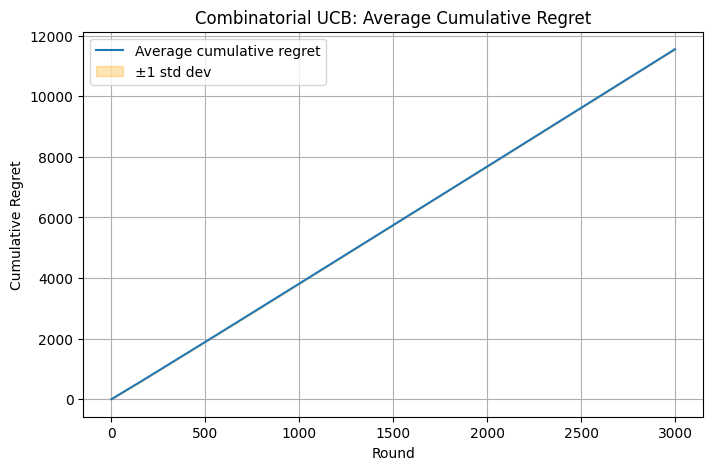

In [8]:
import matplotlib.pyplot as plt

# -------------------------
# Plot average cumulative regret
# -------------------------
plt.figure(figsize=(8,5))
plt.plot(avg_regret, label='Average cumulative regret')
plt.fill_between(range(T),
                 avg_regret - regret_sd,
                 avg_regret + regret_sd,
                 color='orange', alpha=0.3, label='±1 std dev')
plt.xlabel('Round')
plt.ylabel('Cumulative Regret')
plt.title('Combinatorial UCB: Average Cumulative Regret')
plt.legend()
plt.grid(True)
plt.show()
